The purpose of this notebook is to inspect and explain different methods for the alignment of shapes in space.<br> 
The idea is to go through several methods, understand their respective method and inspect which one works best in what case.<br>
In addition, we will make use of the Pyssam library for a creation and analysis of a shape model, PCA, and mode variation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyssam
from copy import copy

import utils
import alignment

INFO: Using numpy backend


## 1. Data reading and pre-processing

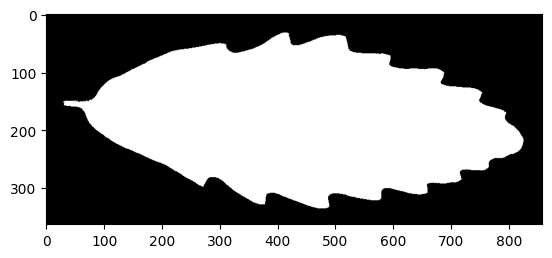

In [2]:
data_path = os.path.join(os.getcwd(), 'data/leaf_dataset/images/')
data_raw = []
for file in sorted(os.listdir(data_path)):
    if file.endswith('.jpg'):
        data_raw.append(plt.imread(data_path + file))

plt.imshow(data_raw[0], cmap = 'gray')
plt.show()

In [3]:
#Extract the contours of the shapes using the built-in function from Matplotlib  
data = []
for shape in data_raw:
    line = plt.contour(shape, levels=[1]).collections[0].get_paths()[0].vertices
    data.append(line)
plt.close()

/tmp/ipykernel_2400697/3540410765.py:4: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  line = plt.contour(shape, levels=[1]).collections[0].get_paths()[0].vertices


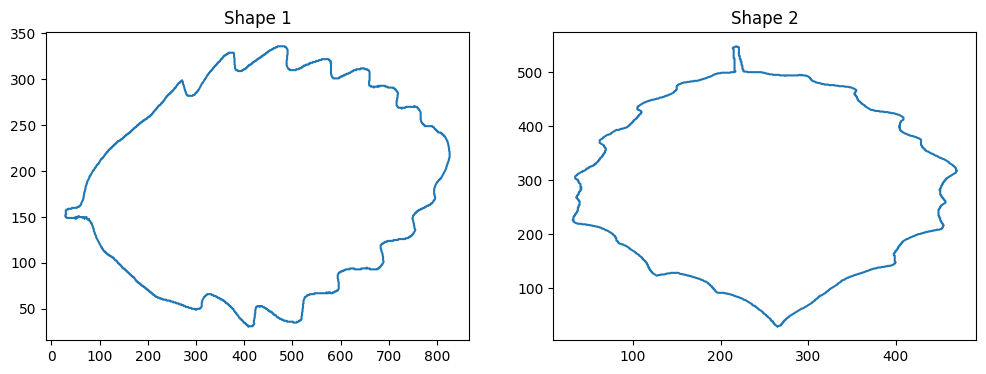

In [4]:
shape_to_plot = 3

fig, ax = plt.subplots(1,2 , figsize = (12,4))
ax[0].plot(data[0][:,0] , data[0][:,1])
ax[1].plot(data[shape_to_plot][:,0] , data[shape_to_plot][:,1])

ax[0].set_title('Shape 1');
ax[1].set_title('Shape 2');

### Interpolation

Before we align the shapes and create a shape model, we must check if all shapes have the same amount of data points.

In [5]:
lengths = []
for curve in data:
    lengths.append(curve.shape[0])
# Run over all shapes and print True if all curves have the same length, otherwise False
base = lengths[0]
check = True
for item in lengths:
    if item != base:
        check = False
        break
print(check)



False


As our shapes are of different lengths, we first use the interpolate function, which transforms every shape to a chosen number of sampling points. The function also makes sure there are no duplicate points in the shape after the interpolation.

In [4]:
nb_points = 500
data_interp = utils.apply_func_to_list(
    input_list=data, func=lambda x: utils.interpolate(x, nb_points)
)

lengths = []
for curve in data_interp:
    lengths.append(curve.shape[0])
# Run over all shapes and print True if all curves have the same length, otherwise False
base = lengths[0]
check = True
for item in lengths:
    if item != base:
        check = False
        break
print(check)

True


## 2. Alignment

### Procrustes alignment

The first alignment method we use is the Procrustes analysis alignment. The standard procrustes analysis uses a shape as a reference shape (usually the first shape in the dataset).<br>
It takes every shape in the dataset and performs standardization (mean 0 and standard deviation 1) and centering around the origin. Then, the shape is transformed (scaled and rotated) to best fit the reference shape, meaning to minimize the sum of squares of the pointwise distances.

** Note - For most alignment methods we make use of the apply_func_to_list function. <br>
The function takes a list (dataset) and an input function and returns a new dataset with the input function (alignment) applied to every element of the original list.

In [7]:
data_procustes = utils.apply_func_to_list(
    input_list=data_interp, func=lambda x: alignment.procrustes(shape = x, ref_shape= data_interp[0])
)


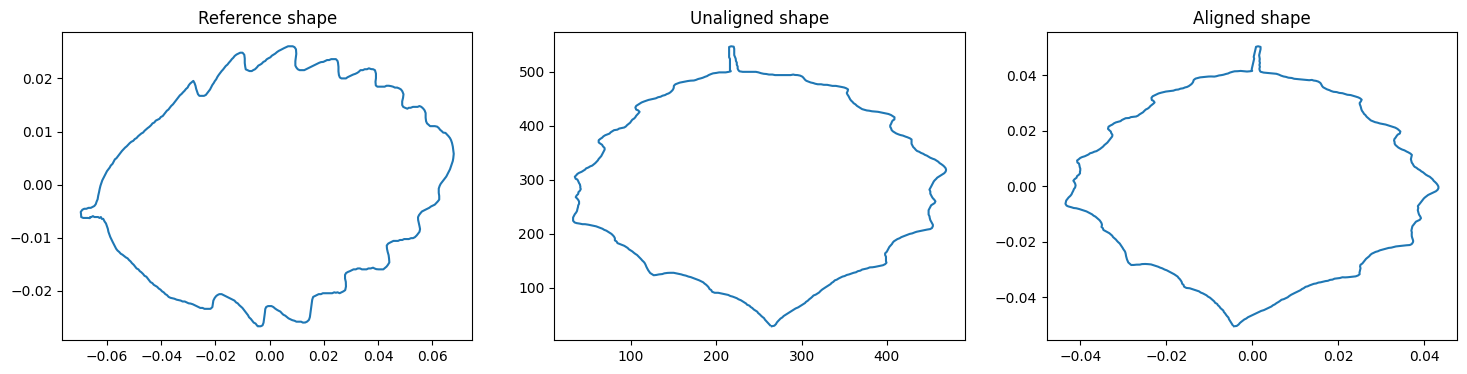

In [8]:
fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(data_procustes[0][:,0] , data_procustes[0][:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])
ax[2].plot(data_procustes[shape_to_plot][:,0] , data_procustes[shape_to_plot][:,1])

ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')

plt.show()

As we can see, the alignment is far from being satisfactory. This is probably due to the fact that our shapes don't have correspondence.<br>
The Procrustes alignment method requires the points of the two shapes to be of a same order, as it finds the best rotation and scale that minimize the pointwise distance. If this is not the case (as in our dataset), the success in properly rotating the shape to align with the reference shape is significantly lower. 

### Procrustes alignment with exhaustive search

In order to deal with the problem presented in the standard Procrustes method, we  perform an exhaustive search. The idea is to find the point order that minimizes the pointwise distance out of all alignment attemps. We iteratively pick a point as a starting point, scale and rotate the shape to align it to the reference shape and move on to try the next point as the starting point. The point that produces the best alignment (smallest pointwise distance) is our best "correspondence" point.

In [9]:
data_ex_procustes = utils.apply_func_to_list(
    input_list=data_interp, func=lambda x: alignment.exhaustive_search(shape = x, ref_shape= data_interp[0])
)

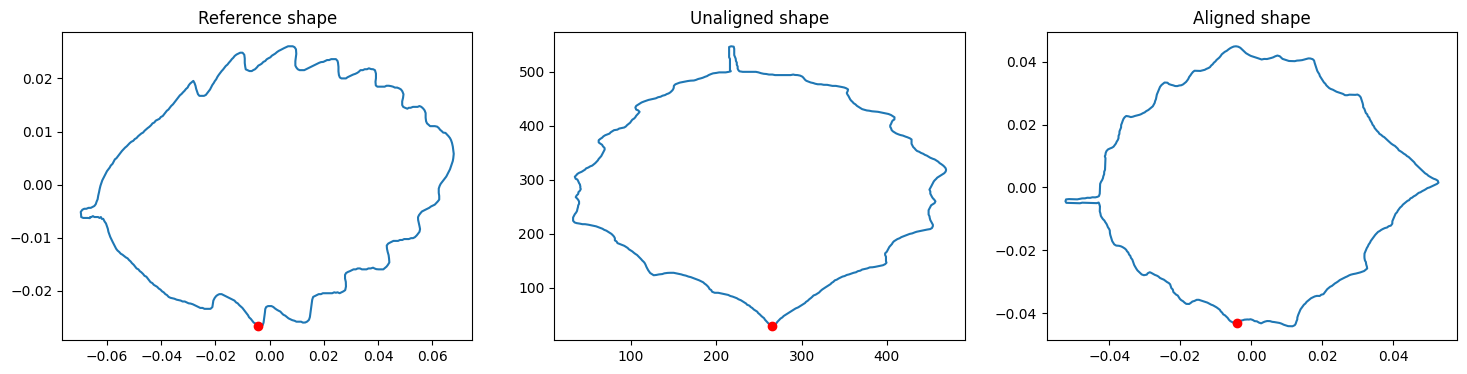

In [10]:
fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(data_ex_procustes[0][:,0] , data_ex_procustes[0][:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])
ax[2].plot(data_ex_procustes[shape_to_plot][:,0] , data_ex_procustes[shape_to_plot][:,1])

ax[0].plot(data_ex_procustes[0][0,0] , data_ex_procustes[0][0,1], "ro")
ax[1].plot(data_interp[shape_to_plot][0,0] , data_interp[shape_to_plot][0,1], "ro")
ax[2].plot(data_ex_procustes[shape_to_plot][0,0] , data_ex_procustes[shape_to_plot][0,1], "ro")

ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')



plt.show()

In the plot above, the same unaligned and aligned shape as in the standard Procrustes alignment are shown. The red dot shows the start point of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve. The starting point (in red) of the aligned curve was also modified to align with the reference.
Clearly, results look much better now as the aligned shape seems to be rotated to better fit the reference shape.



### Generalized Procrustes alignment

Our next alignment method is the generalized Procrustes method. It is quite similar to the standard Procrustes alignment but rather more robust.
As opposed to aligning all shapes to a reference shape as done in standard Procrustes, the generalized algorithm works as following:
1. Choose one shape (usually the first in the dataset) as an initial estimate of the mean shape.
2. Align all shapes to the mean shape
3. Re-estimate the mean from aligned shapes.
4. Align the new mean shape to the old mean shape
5. If not converged, return to step 2.<br>
** Convergence is achieved when the L2 distance between the new and old mean shapes is below a pre-determined tolerance.

In addition, the function takes the parameter ex_search as input, which determines whether the function will perform at each alignment an exhaustive search of the points.


In [11]:
# Note that the generalized procrustes alignment function takes the whole data as input, not just one shape and a reference shape like the other alignment functions.
# Therefore, we don't need to apply the apply_func_to_list function to the data as we did before.
data_gen_procrustes, mean_shape =  alignment.generalized_procrustes(data_interp , ex_search = True , tol = 1e-1)

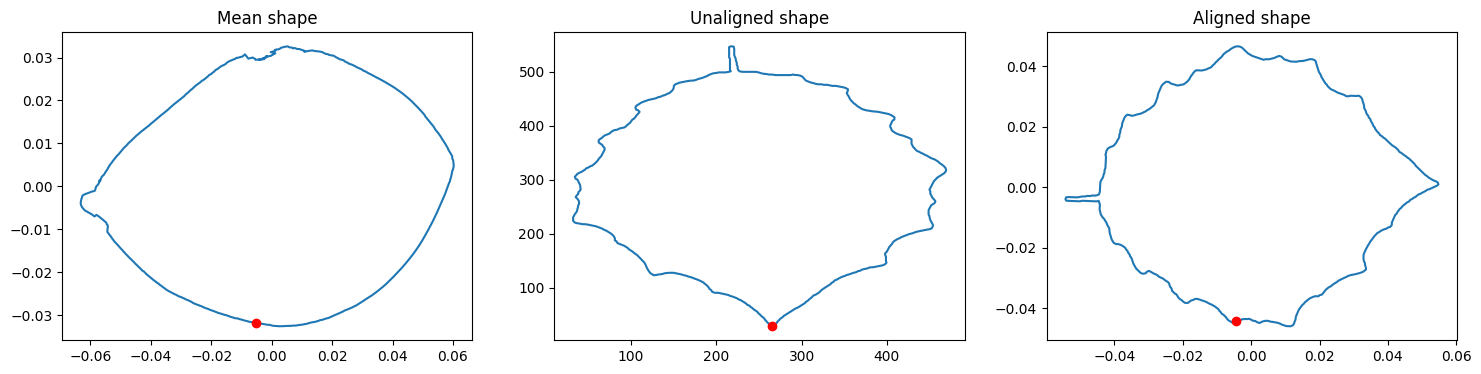

In [12]:
fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(mean_shape[:,0] , mean_shape[:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])
ax[2].plot(data_gen_procrustes[shape_to_plot][:,0] , data_gen_procrustes[shape_to_plot][:,1])

ax[0].plot(mean_shape[0,0] , mean_shape[0,1], "ro")
ax[1].plot(data_interp[shape_to_plot][0,0] , data_interp[shape_to_plot][0,1], "ro")
ax[2].plot(data_gen_procrustes[shape_to_plot][0,0] , data_gen_procrustes[shape_to_plot][0,1], "ro")

ax[0].set_title('Mean shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')



plt.show()

In the plot above, we can inspect the differences between using the generalized and standard Procrustes alignment (with the extra correspondence search). <br>
Visibly enough, the alignment of the shape (right curve) seems to not change much. We can see though that the final reference shape (left curve) is significantly different than before.<br>
This is due to the iterative mean shape assessment for the alignment of the shapes, which makes this alignment technique more robust.

### Alignment through correspondence

In the above examples, we demonstrated how finding the best point order helps to improve the Procrustes alignment and produce the wanted results. Yet sometimes, we have some prior information about the shapes which we want to utilize. This is called correspondence between that shapes. <br>
Correspondence means that every shape has a point or a set of points that can be identified and represent something meaningful in the shape. For proper alignment results, these points must be at the same position when aligning the shape. In this leaf example, each shape has a stalk on one side and a stem on the other.

Below as an example of a leaf shape that was properly rotated to minimize the pointwise distance, but is visibly rotated to the wrong direction. This is because the best solution of the alignment  parameterization problem doesn't necessarily coincide with the shapes' correspondence. <br><br>

The red dot represents the starting point. Even though the dot on the right shape (aligned) moved from the dot on the middle shape (unaligned) according to the best solution, the rotation does not seem correct.

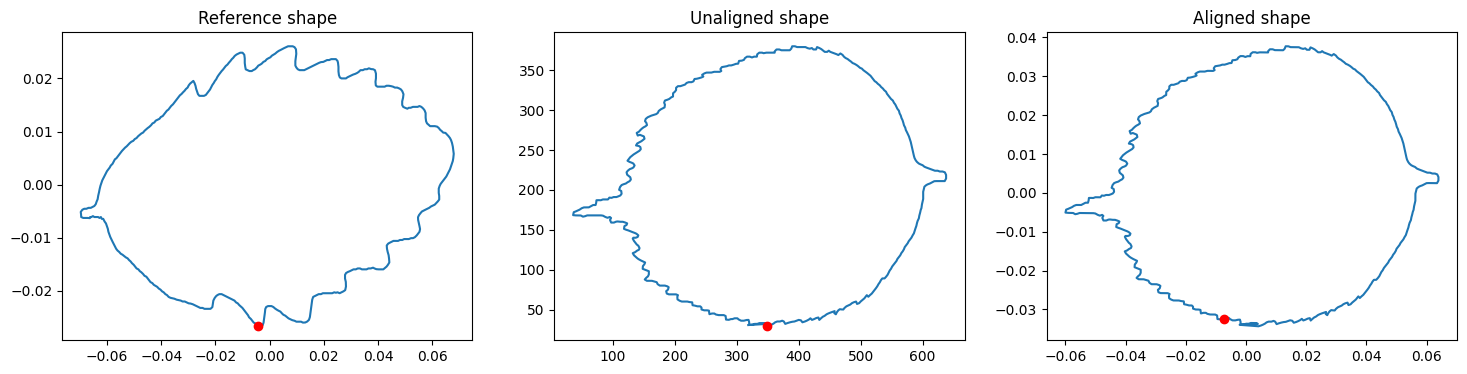

In [13]:
shape_to_plot = 1


fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(data_ex_procustes[0][:,0] , data_ex_procustes[0][:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])
ax[2].plot(data_gen_procrustes[shape_to_plot][:,0] , data_gen_procrustes[shape_to_plot][:,1])

ax[0].plot(data_ex_procustes[0][0,0] , data_ex_procustes[0][0,1], "ro")
ax[1].plot(data_interp[shape_to_plot][0,0] , data_interp[shape_to_plot][0,1], "ro")
ax[2].plot(data_gen_procrustes[shape_to_plot][0,0] , data_gen_procrustes[shape_to_plot][0,1], "ro")

ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')



plt.show()

Below is an example of the correspondence points marked on the reference shape and shpae of interest. The larger dot represents the tip of each leaf and the two other dots represent the stalk.

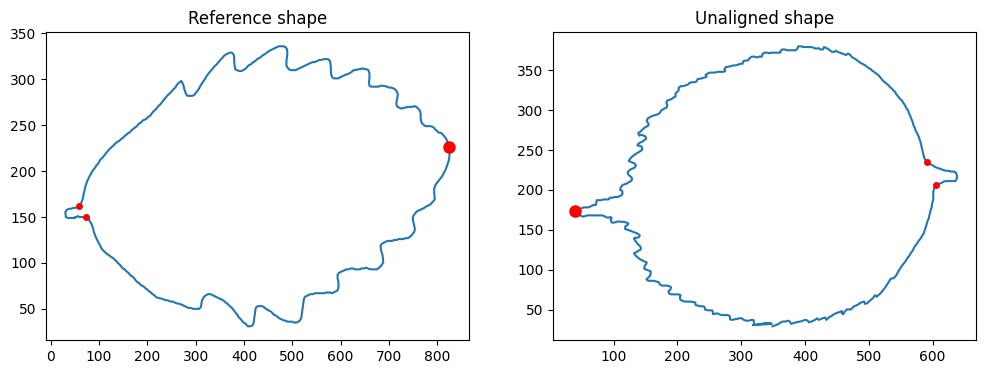

In [107]:
shape_to_plot = 1

fig, ax = plt.subplots(1,2 , figsize = (12,4))
ax[0].plot(data_interp[0][:,0] , data_interp[0][:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])

ax[0].plot(data_interp[0][140,0] , data_interp[0][140,1], "ro" , markersize = 8)
ax[0].plot(data_interp[0][380,0] , data_interp[0][380,1], "ro" , markersize = 4)
ax[0].plot(data_interp[0][401,0] , data_interp[0][401,1], "ro" , markersize = 4)

ax[1].plot(data_interp[shape_to_plot][366,0] , data_interp[shape_to_plot][366,1], "ro",  markersize = 8)
ax[1].plot(data_interp[shape_to_plot][108,0] , data_interp[shape_to_plot][108,1], "ro",  markersize = 4)
ax[1].plot(data_interp[shape_to_plot][132,0] , data_interp[shape_to_plot][132,1], "ro",  markersize = 4)


ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')



plt.show()

As we can see, the correspondence points lie in different locations of the shape (different indexes). <br> Our goal is to first make sure the correspondence points are in the same indexes in each shape, and then perform a Procrustes alignment on shapes with the re-arranged points. <br>

To do so, we use the apply_correspondence function. The function takes as input a list of shapes and a correspondence points list. The correspondence list contains the indexes of each shape's correspondence points and must be of the same order as the shape list.<br>
In addition, the correspondence points in each individual correspondence list must be of the same order and in a continious manner along the shape. In our example, all correspondence lists are ordered as tip, left side of stalk and then right side.<br><br>
The correspondence list must be prepared separately and according to the dataset, often manually.

In [7]:
corr_list = [[140,380,401],[366,108,132], [0,248,255], [0,240,265], [0,249,274], [0,250,258], [162,372,389], [0,231,269], [0,238,265], [107,357,367], [15,247,264],
             [0, 238, 256], [3,236,267], [126,386,395], [0,232,245],  [0,253,275]]
shape_list = [data_interp[0] , data_interp[1], data_interp[2], data_interp[3] , data_interp[4], data_interp[5], data_interp[6], data_interp[7], data_interp[8],
              data_interp[9], data_interp[10], data_interp[11], data_interp[12],  data_interp[13] , data_interp[14], data_interp[15]] 
new_shapes , dists = alignment.apply_correspondence(shape_list, corr_list)


In [8]:
data_corr_procustes = utils.apply_func_to_list(
    input_list=new_shapes, func=lambda x: alignment.procrustes(shape = x, ref_shape= new_shapes[0])
)

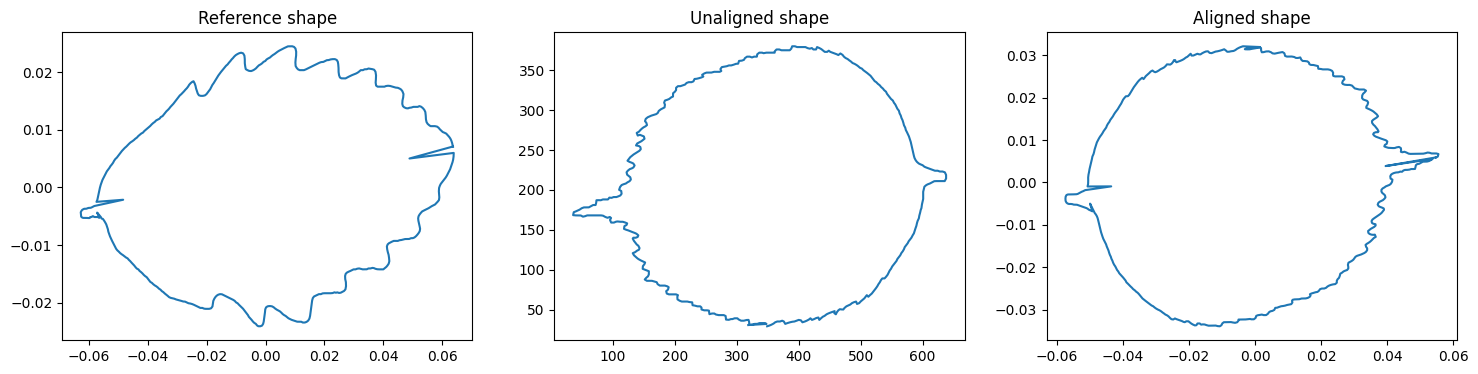

In [9]:
shape_to_plot = 1

fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(data_corr_procustes[0][:,0] , data_corr_procustes[0][:,1])
ax[1].plot(data_interp[1][:,0] , data_interp[1][:,1])
ax[2].plot(data_corr_procustes[shape_to_plot][:,0] , data_corr_procustes[shape_to_plot][:,1])


ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')

plt.show()

### Shape Model

Next, we create a statistical shape model using the Pyssam library. <br>
This library has quick and easy implementations of various shape-model's elements such as PCA analysis and new instance creation based on modification of a selected mode's weights.
The library does not have an implementation of a full alignment process (it only performs centering around the origin and standardization of the data). For that reason, we use the aligned data which was created above.

In [64]:
#Turn the data into a numpy array to fit the Pyssam library
array_corr_procrustes = np.array(data_corr_procustes).reshape(-1,len(data_corr_procustes[0]),2)
shape_model = pyssam.SSM(array_corr_procrustes)

#### Mean Shape

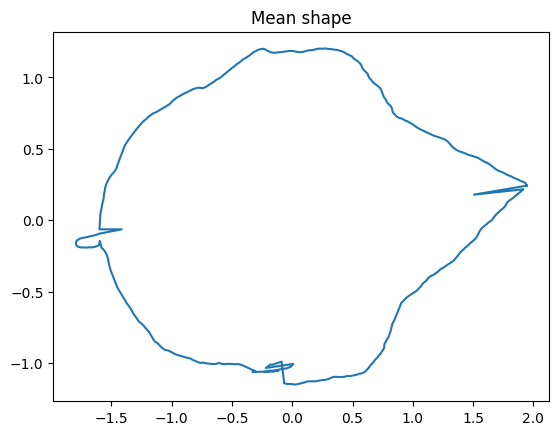

In [65]:
mean_shape_columnvector = shape_model.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 2)

plt.plot(mean_shape[:,0], mean_shape[:,1])
plt.title('Mean shape')
plt.show()

#### PCA Analysis

In [67]:
shape_model.create_pca_model(shape_model.landmarks_columns_scale)
shape_model_componenets = shape_model.pca_model_components

To obtain 90.0% variance, 3 modes are required


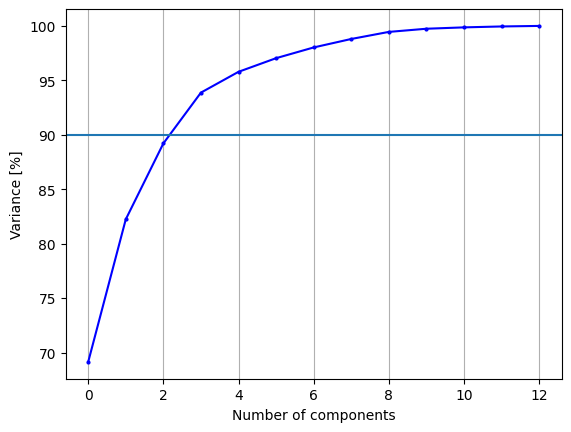

In [68]:
def plot_cumulative_variance(explained_variance, target_variance=0.9):
    top_threshold = np.where(np.cumsum(shape_model.pca_object.explained_variance_ratio_) > 0.99999999)[0][0]
    number_of_components = np.arange(0, top_threshold +1 )
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance[0:top_threshold+1]*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)

    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()

print(f"To obtain {shape_model.desired_variance*100}% variance, {shape_model.required_mode_number} modes are required")
plot_cumulative_variance(np.cumsum(shape_model.pca_object.explained_variance_ratio_), 0.9)

Next we visualise the first 3 prinipal components, inspecting how they change the mean shape.

In [69]:
def plot_shape_modes(
  mean_shape_columnvector,
  mean_shape,
  original_shape_parameter_vector,
  shape_model_components,
  mode_to_plot,
):
  weights = [-3, 0, 3]
  fig, ax = plt.subplots(1, 3 , figsize = (18,4))
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = shape_model.morph_model(
        mean_shape_columnvector,
        shape_model_components,
        shape_parameter_vector
    ).reshape(-1, 2)


    if weights_i == 0:
      ax[j].plot(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].plot(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")

    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()


explained variance is 69.14%


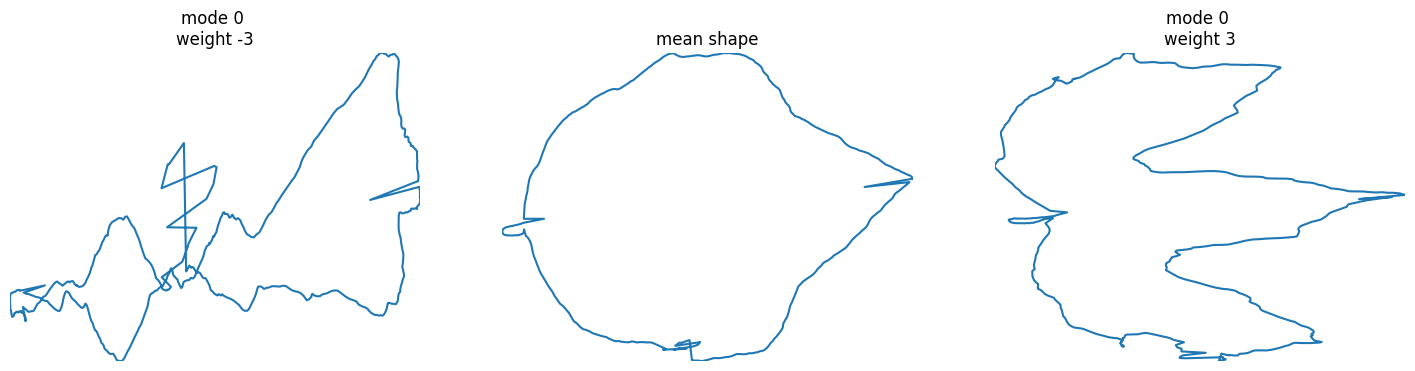

In [70]:
mode_to_plot = 0
print(f"explained variance is {np.round(shape_model.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    shape_model.model_parameters,
    shape_model.pca_model_components,
    mode_to_plot,
)

explained variance is 13.1%


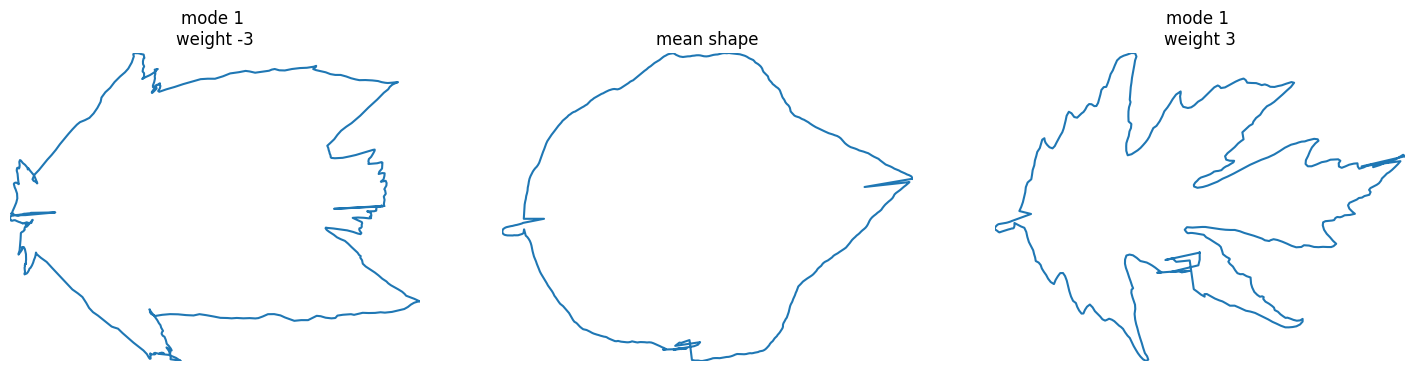

In [71]:
mode_to_plot = 1
print(f"explained variance is {np.round(shape_model.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    shape_model.model_parameters,
    shape_model.pca_model_components,
    mode_to_plot,
)

explained variance is 6.97%


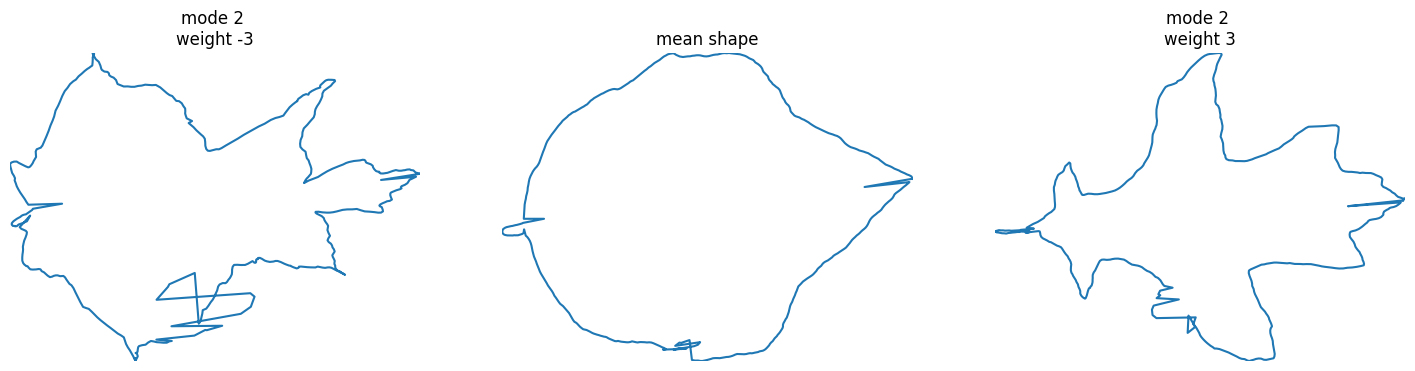

In [72]:
mode_to_plot = 2
print(f"explained variance is {np.round(shape_model.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    shape_model.model_parameters,
    shape_model.pca_model_components,
    mode_to_plot,
)